# Simulating Language, Lab 3, Frequency learning and regularisation

This week we'll be working with a simple Bayesian model of frequency learning.  This simulation allows you to explore the effects of the prior and the data on frequency learning, as discussed in the lecture as a model of the Hudson-Kam & Newport (2005) experiment; next week we'll use the same model to move beyond studying individuals and start looking at cultural evolution.

## The code

The basic framework is the same as the word learning code: after some preliminaries we lay out a hypothesis space, specify the likelihood and the prior, then we have everything we need to calculate the posterior and do Bayesian inference. All the details are different from the word learning lab, because we are modelling a different aspect of language learning, but the code will hopefully already look somewhat familiar.

### Libraries etc
First, we'll load the `random` library (for generating random numbers) and the `prod` function (for multiplying a list of numbers), plus one more library for doing stuff with beta distributions, which we are using for our prior. We also have to load the plotting library and set up inline plots. 

In [1]:
import random
from numpy import prod
from scipy.stats import beta

%matplotlib inline
import matplotlib.pyplot as plt


### Some useful functions for dealing with probabilities

The code starts with two functions we need for doing stuff with probabilities. You saw `normalize_probs` last week, it will take a list of numbers and normalise them for us (i.e. scaling them so they sum to 1). `roulette_wheel` takes a list of probabilities and selects a random index from that list, with probability of any particular index being selected being given by its probability (i.e. if index 0 has twice the probability as index 1, it's twice as likely to be selected). These functions are used elsewhere in the code, but it is not particularly important that you understand exactly how they work. 

In [2]:
def normalize_probs(probs):
    """Takes a list of numbers; returns a list of scaled versions of those numbers that, together, sum to 1."""
    total = sum(probs) #calculates the summed probabilities
    normedprobs = []
    for p in probs:
        normedprobs.append(p / total) #normalise - divide by summed probs
    return normedprobs

def roulette_wheel(normedprobs):
    """Takes a list of normed probabilities; returns some index of that list 
    with probability corresponding to the value of that list element"""
    r=random.random() #generate a random number between 0 and 1
    accumulator = normedprobs[0]
    for i in range(len(normedprobs)):
        if r < accumulator:
            return i
        accumulator = accumulator + normedprobs[i + 1]


### The hypothesis space
The main part of the code starts by laying out our hypothesis space, the candidate hypotheses that our learner is going to consider. As discussed in class, we are going to turn the problem of inferring a potentially continuous value (the probability with which your teacher uses word 1) into the problem of inferring one of a limited set of possible values (either your teacher is using the word with probability 0.005, or 0.015, or 0.025, etc). In the code we will refer to a certain probability of using word 1 as `pW1` (in the lectures I referred to it as $\theta$).  We will call the set of possible values for `pW1` the grid – you can set the granularity of the grid as high as you like, but 100 works OK without being too slow. 

In [3]:
grid_granularity = 100 #How many values of pW1 do you want to consider? Setting this to 100.
grid_increment = 1 / grid_granularity
 
# sets up the grid of possible values of pW1 to consider
possible_pW1 = []
for i in range(grid_granularity):
    possible_pW1.append(grid_increment / 2 + (grid_increment * i))


Have a look at `possible_pW1`. Does it look like you expected?

In [4]:
possible_pW1

[0.005,
 0.015,
 0.025,
 0.034999999999999996,
 0.045,
 0.055,
 0.065,
 0.07500000000000001,
 0.085,
 0.095,
 0.10500000000000001,
 0.115,
 0.125,
 0.135,
 0.14500000000000002,
 0.155,
 0.165,
 0.17500000000000002,
 0.185,
 0.195,
 0.20500000000000002,
 0.215,
 0.225,
 0.23500000000000001,
 0.245,
 0.255,
 0.265,
 0.275,
 0.28500000000000003,
 0.295,
 0.305,
 0.315,
 0.325,
 0.335,
 0.34500000000000003,
 0.35500000000000004,
 0.365,
 0.375,
 0.385,
 0.395,
 0.405,
 0.41500000000000004,
 0.425,
 0.435,
 0.445,
 0.455,
 0.465,
 0.47500000000000003,
 0.485,
 0.495,
 0.505,
 0.515,
 0.525,
 0.535,
 0.545,
 0.555,
 0.5650000000000001,
 0.5750000000000001,
 0.585,
 0.595,
 0.605,
 0.615,
 0.625,
 0.635,
 0.645,
 0.655,
 0.665,
 0.675,
 0.685,
 0.6950000000000001,
 0.7050000000000001,
 0.715,
 0.725,
 0.735,
 0.745,
 0.755,
 0.765,
 0.775,
 0.785,
 0.795,
 0.805,
 0.8150000000000001,
 0.8250000000000001,
 0.8350000000000001,
 0.845,
 0.855,
 0.865,
 0.875,
 0.885,
 0.895,
 0.905,
 0.915,
 0.9

One thing you might notice (you might already have noticed it last week), and be a bit surprised about, is that there are rounding errors! Instead of the probabilities in the grid being exactly 0.05 apart, sometimes the values are over or under by a tiny amount. Working with probabilities on a computer can be a problem, because the computer cannot exactly represent real numbers (i.e. numbers we would write in decimal notation, e.g. numbers like 0.1, 3.147). Your computer has a very large memory where it can store and manipulate numbers, but the problem is that this memory is necessarily finite (it has to fit in your computer) and there are infinitely many real numbers. Think of recurring decimal you get by dividing 1 by 3, 0.3333..., where the threes go on forever - it would take an infinite amount of space to exactly represent this number in your computer, and distinguish it from a very similar number, e.g. 0.33333... where the threes go on for a few thousand repetitions only. More relevantly for the rounding errors above, imagine how much memory it would take to distinguish 0.5 from 0.50000000000...00001, where there could be arbitrarily many decimal places. Spoiler: it would take an infinite memory to do this perfectly. So there’s no way your computer can exactly represent every possible real number. What it does instead is store numbers as accurately as it can, which involves introducing small rounding errors, rounding a number it can't represent to a number it can (and sometimes the results there are slightly un-intuitive to us, like rounding 0.035 to 0.034999999999999996). In fact your computer does its best to conceal these errors from you, and often displays numbers in a format that hides exactly what numbers it is actually working with. But you can see those rounding errors here. Next week we are going to be forced to introduce a technique to deal with these rounding errors otherwise they start causing glitches in the code, but for this week we'll try to live with them.

Next up come the various functions we need for Bayesian inference. I will step through these gradually.

### The prior
For this model our prior is more complicated than last week – we are modelling the prior using a *beta distribution*, which is a family of probability distributions that can capture a uniform prior (representing an unbiased learner), a prior favouring regularity, or a prior favouring variability. 

The `calculate_prior` function calculates the prior probability of each of our possible values of `pW1`. The beta distribution, which is what we are using for our prior, is a standard probability distribution, so we can just use a function from a library (`beta.pdf`) to get the probability density for each value of `pW1`, then normalise those to convert them to probabilities. The `alpha` parameter determines the shape of our prior, and therefore the bias of our learners when it comes to inferring `pW1`.

In [5]:
def calculate_prior(alpha, possible_pW1):
    """Takes in the shape parameter of a symmetrical beta distribution and possible probabilities for word 1;
    returns a list of prior probabilities, one per element in our hypothesis space.
    """
    prior = []
    for pW1 in possible_pW1:
        prior.append(beta.pdf(pW1, alpha, alpha)) #look up the value using beta.pdf and add to our growing prior
    return normalize_probs(prior) #normalize the final list so they are all probabilities


Plot some different prior probability distributions. To get a line graph, try typing e.g. 
```python
plt.plot(possible_pW1, calculate_prior(0.1, possible_pW1))
``` 
to see the prior probability distribution over various values of pW1 for the alpha=0.1 prior. Or, if you prefer a barplot (one bar per value of pW1) do 
```python
plt.bar(possible_pW1,calculate_prior(0.1, possible_pW1),align='center',width=1./grid_granularity)
``` 
(`align='center'` and `width=1./grid_granularity` makes sure your x-axis looks right and the bars line up where they should). 

Play around with the code, trying different values for the alpha parameter, to answer these three questions: 
- What values of alpha lead to a prior bias for regularity (i.e. higher prior probability for pW1 closer to 0 or 1)? 
- What values of alpha lead to a prior bias for variability (i.e. higher prior probability for pW1 closer to 0.5)? 
- What values of alpha lead to a completely unbiased learner (i.e. all values of pW1 are a priori equally likely)?

*Here's a way to get three lines on a single plot - the red line shows the prior where alpha=0.1, the blue line is alpha=1, the green line is alpha=5. Notice that I can specify plot colours in the plot if I want, and the `label=` bit in the plot command tells it what to put in the plot legend, which I add with `plt.legend()`*

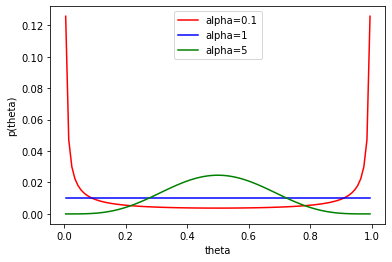

In [6]:
plt.plot(possible_pW1, calculate_prior(0.1, possible_pW1),'red',label="alpha=0.1")
plt.plot(possible_pW1, calculate_prior(1, possible_pW1),'blue',label="alpha=1")
plt.plot(possible_pW1, calculate_prior(5, possible_pW1),'green',label="alpha=5")
plt.xlabel("theta")
plt.ylabel("p(theta)")
plt.legend()

*Here's the same priors presented as barplots - 3 seperate plots, because tripling up on bars looks horrible, note the different plots have different y-axes.*

Text(0, 0.5, 'p(theta)')

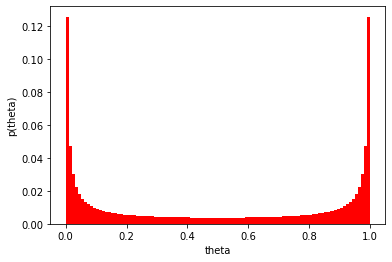

In [7]:
plt.bar(possible_pW1,calculate_prior(0.1, possible_pW1),color='red',align='center',width=1./grid_granularity)
plt.xlabel("theta")
plt.ylabel("p(theta)")

Text(0, 0.5, 'p(theta)')

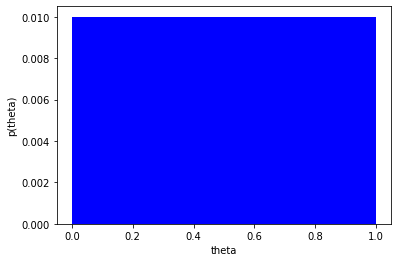

In [8]:
plt.bar(possible_pW1,calculate_prior(1, possible_pW1),color='blue',align='center',width=1./grid_granularity)
plt.xlabel("theta")
plt.ylabel("p(theta)")

Text(0, 0.5, 'p(theta)')

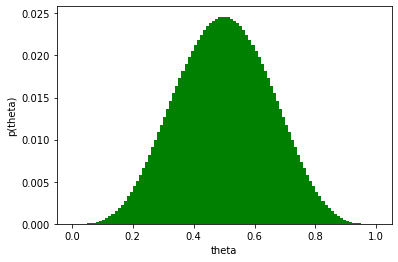

In [9]:
plt.bar(possible_pW1,calculate_prior(5, possible_pW1),color='green',align='center',width=1./grid_granularity)
plt.xlabel("theta")
plt.ylabel("p(theta)")

*Answering the 3 questions in turn:*

*__What values of alpha lead to a prior bias for regularity (i.e. higher prior probability for pW1 closer to 0 or 1)?__*

*Any alpha lower than 1 gives U-shaped priors which lead to a preference for extreme (i.e. very low or very high) values of pW1, which corresponds to a learner who assumes that the probability of word 1 should be extreme (i.e. close to 0 or close to 1); this is a bias in favour of regularity, because the learners are dispreferring intermediate values of pW1, i.e. the language where word 0 and word 1 occur equally often. The lower the value of alpha the stronger the bias for regularity, i.e. the more extreme the U-shape. I have illustrated this below with four values of alpha all below 1 - note that when alpha is just below 1 the line is nearly flat, when alpha is very small the curve gets more extreme but it's actually hard to see the difference between alpha=0.1 and alpha=0.001.*

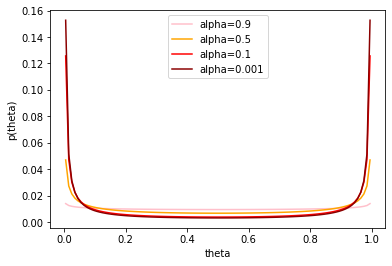

In [10]:
plt.plot(possible_pW1, calculate_prior(0.9, possible_pW1),'pink',label='alpha=0.9')
plt.plot(possible_pW1, calculate_prior(0.5, possible_pW1),'orange',label='alpha=0.5')
plt.plot(possible_pW1, calculate_prior(0.1, possible_pW1),'red',label='alpha=0.1')
plt.plot(possible_pW1, calculate_prior(0.001, possible_pW1),'darkred',label='alpha=0.001')
plt.xlabel("theta")
plt.ylabel("p(theta)")
plt.legend()

*Reproducing the pink plot here as a bar chart so you can see the U-shape better.*

Text(0, 0.5, 'p(theta)')

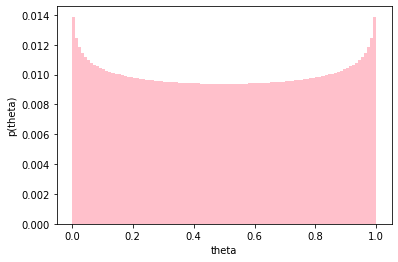

In [11]:
plt.bar(possible_pW1,calculate_prior(0.9, possible_pW1),color='pink',align='center',width=1./grid_granularity)
plt.xlabel("theta")
plt.ylabel("p(theta)")

*__What values of alpha lead to a prior bias for variability (i.e. higher prior probability for pW1 closer to 0.5)?__*

*Any alpha higher than 1 gives inverted-U priors which lead to a preference for intermediate (i.e. around 0.5) values of pW1, which corresponds to a learner who assumes that word 0 and word 1 should occur equally often, i.e. that the language should be variable. The higher the value of alpha the stronger the bias for variability, i.e. the more extreme the inverted-U.*

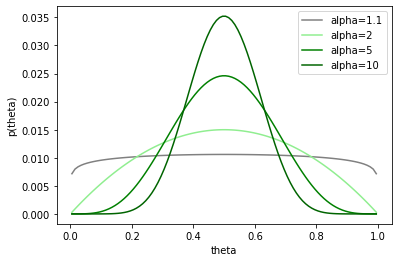

In [12]:
plt.plot(possible_pW1, calculate_prior(1.1, possible_pW1),'grey',label='alpha=1.1')
plt.plot(possible_pW1, calculate_prior(2, possible_pW1),'lightgreen',label='alpha=2')
plt.plot(possible_pW1, calculate_prior(5, possible_pW1),'green',label='alpha=5')
plt.plot(possible_pW1, calculate_prior(10, possible_pW1),'darkgreen',label='alpha=10')
plt.xlabel("theta")
plt.ylabel("p(theta)")
plt.legend()

*__What values of alpha lead to a completely unbiased learner (i.e. all values of pW1 are a priori equally likely)?__*

*You only get a completely flat prior when alpha=1, although note that we can have slight biases for regularity or variability when alpha is close to 1 - see the plots for alpha=0.9 and alpha=1.1. Note that the range on the y axis here is quite small, these are not huge differences, but only the alpha=1 line is completely flat.*


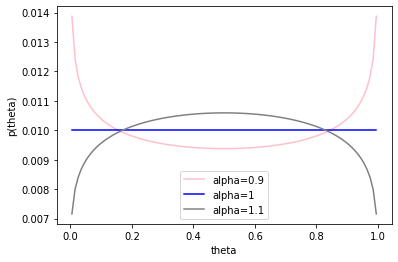

In [13]:
plt.plot(possible_pW1, calculate_prior(0.9, possible_pW1),'pink',label='alpha=0.9')
plt.plot(possible_pW1, calculate_prior(1, possible_pW1),'blue',label='alpha=1')
plt.plot(possible_pW1, calculate_prior(1.1, possible_pW1),'grey',label='alpha=1.1')
plt.xlabel("theta")
plt.ylabel("p(theta)")
plt.legend()

### Likelihood and production

In order to do Bayesian inference, we need a likelihood function that tells us how probable some data is given a certain hypothesis (a value of `pW1`) – that's our `likelihood()` function. Next week we are also going to need a way of modelling production – taking an individual, with a value of `pW1` in their head, and having them produce data that someone else can learn from. We'll specify that now too, it's called `produce()`. 

We are going to model data – a sequence of utterances – as a simple list of 0s and 1s: the 0s correspond to occurrences of word 0, the 1s correspond to occurrences of word 1. For example, this is how we will represent a data set consisting of one occurence of word 0 and one occurence of word 1:
```python
small_data = [0,1]
```

How would you represent a dataset consisting of two occurences of word 0 and two occurences of word 1?

Both the `likelihood()` function and the `produce()` function take as an argument the probability of word 1 being produced, `pW1`, and use that to calculate the probability of word 0 being produced (which is `1 - pW1`: in this model there are only two words, every time you produce an utterance you produce one or the other). The `likelihood()` function calculates the likelihood of `data`, a list of utterances, given a particular value of `pW1`. The `produce()` function generates some data for a speaker with a specific value of `pW1` in their head – you tell it how many productions you want (`n_productions`) and it spits out a list of data for you. 

In [14]:
def likelihood(data, pW1):
    """Takes data (list of numbers) and hypothesis (a single probability);
       returns the probability of the given hypothesis generating the observed data."""
    pW0 = 1 - pW1 #probability of w0 is 1-prob of w1
    probs = [pW0, pW1]
    likelihoods = []
    for d in data:
        likelihood_this_item = probs[d] #d will be either 0 or 1, so we can use as an index
        likelihoods.append(likelihood_this_item)
    return prod(likelihoods) #multiply the probabilities of the individual data items
    
def produce(pW1, n_productions):
    """Takes probability of word 1 being produced and the number of productions to generate;
       returns list of numbers (0 or 1), with 1 sampled with the probability given in pW1"""
    pW0 = 1 - pW1
    probs = [pW0, pW1]
    data = []
    for p in range(n_productions):
        data.append(roulette_wheel(probs))
    return data

- Test out the `produce()` function – decide on a probability for w1 and then specify how many utterances you would like to produce. What kind of data will be produced if the probability of w1 is low? Or if it is high? Hint: `produce(0.1,10)` will produce 10 utterances with the probability of producing word 1 on each utterance being 0.1. 

*If pW1 is low we get lots of occurences of w0 (i.e. lots of 0s in the list of data `produce()` returns); if pW1 is high we get lots of occurences of w1; if pW1 is around 0.5 we should get a roughly even mix of w0 and w1. Note that the `produce()` function is stochastic (i.e. it has a random component) - every time we run it we get a different sample.*

In [15]:
print(produce(0.1,10))
print(produce(0.1,10))
print(produce(0.1,10))

[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 0, 0, 0, 0, 0, 1, 0, 0]


In [16]:
print(produce(0.9,10))
print(produce(0.9,10))
print(produce(0.9,10))

[1, 1, 1, 1, 1, 1, 0, 1, 0, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 0, 1, 0]


In [17]:
print(produce(0.5,10))
print(produce(0.5,10))
print(produce(0.5,10))

[0, 0, 0, 1, 1, 1, 1, 0, 1, 1]
[1, 0, 1, 1, 1, 0, 0, 0, 1, 1]
[0, 0, 1, 0, 1, 1, 0, 1, 1, 1]


- Next, check out the likelihood function – how does the likelihood of a set of data depend on the data and the probability of word 1? Hint: `likelihood([0,0,1,1],0.5)` will tell you the likelihood of producing word 0 twice then word 1 twice when the probability of producing word 1 each time is 0.5. Try plugging in different sequences of data and different values for `pW1`.

*As I said in class: if pW1 is low then data with lots of 0s is likely and data with lots of 1s is very unlikely; if pW1 is high then data with lots of 0s is very unlikely and data with lots of 1s is likely; if pW1 is around 0.5 then all sequences of data are equally likely.*

In [18]:
print(likelihood([0,0,0,0,0,0],0.1))
print(likelihood([0,0,0,1,1,1],0.1))
print(likelihood([1,1,1,1,1,1],0.1))

0.5314410000000002
0.0007290000000000002
1.0000000000000004e-06


In [19]:
print(likelihood([0,0,0,0,0,0],0.5))
print(likelihood([0,0,0,1,1,1],0.5))
print(likelihood([1,1,1,1,1,1],0.5))

0.015625
0.015625
0.015625


In [20]:
print(likelihood([0,0,0,0,0,0],0.9))
print(likelihood([0,0,0,1,1,1],0.9))
print(likelihood([1,1,1,1,1,1],0.9))

9.999999999999987e-07
0.0007289999999999996
0.5314410000000002


### Learning

Now we have all the bits we need to calculate the posterior probability distribution – that's what the `posterior()` function does, and it works in exactly the same way as the `posterior()` function from lab 2. We are also going to make a function, with we will call `learn()`, which picks a hypothesis (a value of pW1) based on its posterior probability – again, we'll be needing this next week, but you can play with it now. 

In [21]:
def posterior(data, prior, possible_pW1):
    """Takes data (list of numbers), prior (list of prior probabilities for each hypothesis), 
       and list of possible probabilities for word 1;
       returns list of probabilities, one per hypothesis."""
    posterior_probs = [] #this list will hold the posterior for each possible value of pW1
    for i in range(len(possible_pW1)): #work through the list of pW1 values, by index
        pW1 = possible_pW1[i] #look up that value of pW1
        p_h = prior[i] #look up the prior probability of this pW1
        p_d = likelihood(data, pW1) #calculate the likelihood of data given this pW1
        p_h_given_d = p_h * p_d #multiply prior x likelihood
        posterior_probs.append(p_h_given_d) 
    return normalize_probs(posterior_probs) #normalise
     
def learn(data, prior, possible_pW1):
    """Takes data (list of numbers), prior (list of prior probabilities for each hypothesis),
       and list of possible probabilities for word 1;
       Returns a single hypothesis, selected proportional to its posterior probability."""
    posterior_probs = posterior(data, prior, possible_pW1) #calculate the posterior
    selected_index = roulette_wheel(posterior_probs) #select a random index from the posterior
    return possible_pW1[selected_index] #look up the corresponding value of pW1

The `posterior()` function implements Bayes' Rule for us – the posterior probability of each value of `pW1` given the data is the likelihood of the data given that value of `pW1` multiplied by the prior probability of that value of `pW1`. 

Test out the `posterior()` function. To do this you will need to build a prior, and make some data for your learner to learn from; you might also want to plot the posterior rather than staring at a big list of numbers. For example:
```python
my_prior = calculate_prior(1, possible_pW1)
my_data = [0] * 2 + [1] * 2
print('data = ',my_data)
my_posterior = posterior(my_data, my_prior, possible_pW1)
plt.plot(possible_pW1, my_posterior)
```

This example shows how to test a uniform prior (alpha = 1) and data consisting of two 1s and two 0s (note that there is a cute little trick there for creating lists of duplicates and sticking two lists together). Then it calculates the posterior probability for all possible values of `pW1` and plots it (the x-axis in the graph shows value of `pW1`, the y-axis shows the posterior probability of that value of `pW1` given `my_data`). 

Start with a uniform prior and see how the data affects the learner’s hypothesis. 

- What does adding more data do?

*I am going to plot three posteriors on one graph, representing the posterior after learning from three different sets of data with the unfirom prior (alpha=1). The data sets all have equal numbers of word 0 and word 1, but I just double the size of the dataset each time. You can see that when we have relatively little data the peak is on 0.5 (the learner estimates that pW1 is around 0.5) but is quite wide, i.e. there's some uncertainty; the more data we add the tighter the distribution gets, as the learner becomes increasingly confident of their estimate of the word frequencies.*

data1 =  [0, 0, 1, 1]
data2 =  [0, 0, 0, 0, 1, 1, 1, 1]
data3 =  [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]


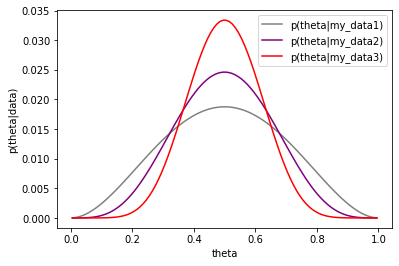

In [22]:
my_prior = calculate_prior(1, possible_pW1)
my_data1 = [0] * 2 + [1] * 2
my_data2 = [0] * 4 + [1] * 4
my_data3 = [0] * 8 + [1] * 8
print('data1 = ',my_data1)
print('data2 = ',my_data2)
print('data3 = ',my_data3)

my_posterior1 = posterior(my_data1, my_prior, possible_pW1)
my_posterior2 = posterior(my_data2, my_prior, possible_pW1)
my_posterior3 = posterior(my_data3, my_prior, possible_pW1)
plt.plot(possible_pW1, my_posterior1,'grey',label='p(theta|my_data1)')
plt.plot(possible_pW1, my_posterior2,'purple',label='p(theta|my_data2)')
plt.plot(possible_pW1, my_posterior3,'red',label='p(theta|my_data3)')
plt.xlabel("theta")
plt.ylabel("p(theta|data)")
plt.legend()

- What does making the data highly skewed in favour of one word do? 

*I'll do the same trick, but this time I'll keep the size of the data constant (8 items) and move from an even split to a heavy skew towards word 1 - you can see that the learner's posterior tracks the frequency of word 1 in the data, the more occurences of word 1, the further right (i.e. higher) the estimate of pW1 becomes.*

data1 =  [0, 0, 0, 0, 1, 1, 1, 1]
data2 =  [0, 0, 0, 1, 1, 1, 1, 1]
data3 =  [0, 0, 1, 1, 1, 1, 1, 1]
data4 =  [0, 1, 1, 1, 1, 1, 1, 1]


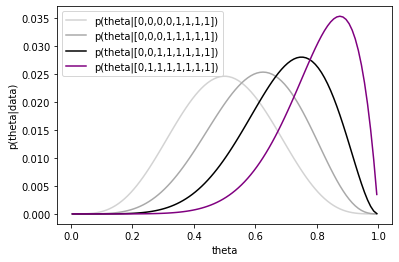

In [23]:
my_prior = calculate_prior(1, possible_pW1)
my_data1 = [0] * 4 + [1] * 4
my_data2 = [0] * 3 + [1] * 5
my_data3 = [0] * 2 + [1] * 6
my_data4 = [0] * 1 + [1] * 7
print('data1 = ',my_data1)
print('data2 = ',my_data2)
print('data3 = ',my_data3)
print('data4 = ',my_data4)

my_posterior1 = posterior(my_data1, my_prior, possible_pW1)
my_posterior2 = posterior(my_data2, my_prior, possible_pW1)
my_posterior3 = posterior(my_data3, my_prior, possible_pW1)
my_posterior4 = posterior(my_data4, my_prior, possible_pW1)
plt.plot(possible_pW1, my_posterior1,'lightgrey',label='p(theta|[0,0,0,0,1,1,1,1])')
plt.plot(possible_pW1, my_posterior2,'darkgrey',label='p(theta|[0,0,0,1,1,1,1,1])')
plt.plot(possible_pW1, my_posterior3,'black',label='p(theta|[0,0,1,1,1,1,1,1])')
plt.plot(possible_pW1, my_posterior4,'purple',label='p(theta|[0,1,1,1,1,1,1,1])')
plt.xlabel("theta")
plt.ylabel("p(theta|data)")
plt.legend()

- Try different priors - what does a strong prior in favour of regularity do? 

*I will just plot the same graph as above, with the same 4 data sets as before, but plug in a regularity prior (alpha=0.1), so you can compare the two graphs to see the effect of the regularity prior.*

data1 =  [0, 0, 0, 0, 1, 1, 1, 1]
data2 =  [0, 0, 0, 1, 1, 1, 1, 1]
data3 =  [0, 0, 1, 1, 1, 1, 1, 1]
data4 =  [0, 1, 1, 1, 1, 1, 1, 1]


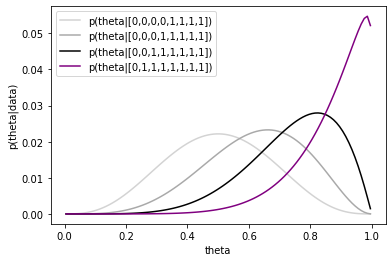

In [24]:
my_regularity_prior = calculate_prior(0.1, possible_pW1)
my_data1 = [0] * 4 + [1] * 4
my_data2 = [0] * 3 + [1] * 5
my_data3 = [0] * 2 + [1] * 6
my_data4 = [0] * 1 + [1] * 7
print('data1 = ',my_data1)
print('data2 = ',my_data2)
print('data3 = ',my_data3)
print('data4 = ',my_data4)
my_posterior1 = posterior(my_data1, my_regularity_prior, possible_pW1)
my_posterior2 = posterior(my_data2, my_regularity_prior, possible_pW1)
my_posterior3 = posterior(my_data3, my_regularity_prior, possible_pW1)
my_posterior4 = posterior(my_data4, my_regularity_prior, possible_pW1)
plt.plot(possible_pW1, my_posterior1,'lightgrey',label='p(theta|[0,0,0,0,1,1,1,1])')
plt.plot(possible_pW1, my_posterior2,'darkgrey',label='p(theta|[0,0,0,1,1,1,1,1])')
plt.plot(possible_pW1, my_posterior3,'black',label='p(theta|[0,0,1,1,1,1,1,1])')
plt.plot(possible_pW1, my_posterior4,'purple',label='p(theta|[0,1,1,1,1,1,1,1])')
plt.xlabel("theta")
plt.ylabel("p(theta|data)")
plt.legend()

*So the effect is that everything gets pushed towards the extreme pW1=1 edge of the plot - if there is a skew in the data (i.e. word 1 is more common than word 0) then the model over-estimates the frequency of word 1 (i.e. estimates a higher pW1). For instance, compare the black line across the two graphs - this is for data `[0,0,1,1,1,1,1,1]`, and the learner with the flat prior has a posterior with a peak around 0.75, i.e. it estimates that the underlying frequency of word 1 is probably around 0.75, which is what the data says. But from the same data the learner with the regularity prior has a peak above 0.8 - they want the language to be regular (only use word 0 or only use word 1), and so given data containing both words this bias causes it to over-estimate the frequency of the more common word.*

- What does a strong prior in favour of variability do?

*In the plots below I have done the same again, but plugged in the alpha=5 prior, which strongly favours pW1 around 0.5, i.e. both words equally frequent. Now you can see the reverse effect - all the posteriors are pulled towards the middle, and even if the data contains quite a strong skew towards word 1 (e.g. the purple line) the learner is under-estimating the frequency of the more common word and pulling everything a bit back towards pW1=0.5. Notice my legend is a bit annoying in this plot, it's obscuring the data which is scruffy!*

data1 =  [0, 0, 0, 0, 1, 1, 1, 1]
data2 =  [0, 0, 0, 1, 1, 1, 1, 1]
data3 =  [0, 0, 1, 1, 1, 1, 1, 1]
data4 =  [0, 1, 1, 1, 1, 1, 1, 1]


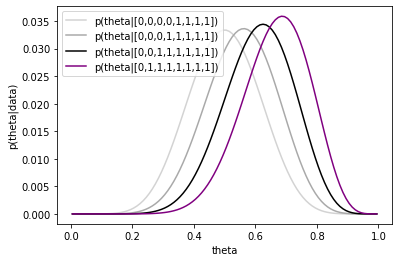

In [25]:
my_variability_prior = calculate_prior(5, possible_pW1)
my_data1 = [0] * 4 + [1] * 4
my_data2 = [0] * 3 + [1] * 5
my_data3 = [0] * 2 + [1] * 6
my_data4 = [0] * 1 + [1] * 7
print('data1 = ',my_data1)
print('data2 = ',my_data2)
print('data3 = ',my_data3)
print('data4 = ',my_data4)
my_posterior1 = posterior(my_data1, my_variability_prior, possible_pW1)
my_posterior2 = posterior(my_data2, my_variability_prior, possible_pW1)
my_posterior3 = posterior(my_data3, my_variability_prior, possible_pW1)
my_posterior4 = posterior(my_data4, my_variability_prior, possible_pW1)
plt.plot(possible_pW1, my_posterior1,'lightgrey',label='p(theta|[0,0,0,0,1,1,1,1])')
plt.plot(possible_pW1, my_posterior2,'darkgrey',label='p(theta|[0,0,0,1,1,1,1,1])')
plt.plot(possible_pW1, my_posterior3,'black',label='p(theta|[0,0,1,1,1,1,1,1])')
plt.plot(possible_pW1, my_posterior4,'purple',label='p(theta|[0,1,1,1,1,1,1,1])')
plt.xlabel("theta")
plt.ylabel("p(theta|data)")
plt.legend()

You can also play about with the `learn()` function, which picks a single value of `pW1` based on the posterior. e.g. try `learn(my_data,my_prior,possible_pW1)` several times. Do you always get the same answer? Why not?

*Like `produce()`, `learn()` is stochastic – we sample a value of pW1 from the posterior, so we are likely to pick values that have high posterior probability but can sometimes pick values of pW1 that have lower posterior probability. In the example below I am using a flat prior (alpha = 1) and data that's 75% word 2 – we should expect the learner's posterior for this data and prior to be somewhat peaked around 0.75. I then use `learn()` 10 times to calculate the posterior and sample a value of pW1 – you should see that the values it spits out (sampled estimates of pW1) tend to be around 0.75, but vary quite a bit.*

In [26]:
my_prior = calculate_prior(1, possible_pW1)
my_data = [0] * 2 + [1] * 6
print(learn(my_data, my_prior, possible_pW1))
print(learn(my_data, my_prior, possible_pW1))
print(learn(my_data, my_prior, possible_pW1))
print(learn(my_data, my_prior, possible_pW1))
print(learn(my_data, my_prior, possible_pW1))
print(learn(my_data, my_prior, possible_pW1))
print(learn(my_data, my_prior, possible_pW1))
print(learn(my_data, my_prior, possible_pW1))
print(learn(my_data, my_prior, possible_pW1))
print(learn(my_data, my_prior, possible_pW1))

0.655
0.775
0.785
0.7050000000000001
0.405
0.915
0.675
0.6950000000000001
0.785
0.7050000000000001


## Questions

The priority for this worksheet is to work through the in-text questions above: experimenting with different shapes for the prior, checking that the `likelihood()` and `produce()` functions makes sense to you, checking you understand how the posterior depends on the prior and the data and that you understand why`learn()` behaves as it does. Once you are happy with that, try these questions:

1. Can you produce a result like the Hudson Kam & Newport (2005) results *for adults*, i.e. that adult learners fairly accurately track the frequency of a linguistic variant in their input? What kinds of priors and what kinds of data does this work for? *Be aware: when using large amounts of data, you might run into the kinds of rounding error I mentioned earlier!* 

*It should be pretty easy to get this model to track the frequency of variants in the input (i.e. probability match) - as long as the prior is not too skewed, or you have enough data, it should end up with a posterior distribution that has its peak roughly where the frequency of word 1 in the data was. For example, here's a reproduction of the graph from earlier, showing the learner with the flat alpha=1 prior tracking the frequency of word 1 in its input. I am adding colour-coded vertical lines so you can see the frequency of word 1 in the input, using `plt.axvline()`*

data1 =  [0, 0, 0, 0, 1, 1, 1, 1]
data2 =  [0, 0, 0, 1, 1, 1, 1, 1]
data3 =  [0, 0, 1, 1, 1, 1, 1, 1]
data4 =  [0, 1, 1, 1, 1, 1, 1, 1]


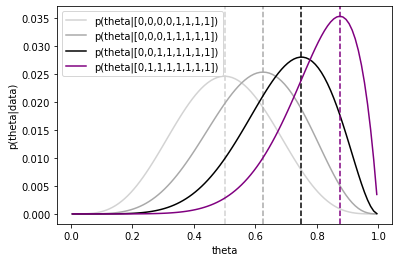

In [27]:
my_prior = calculate_prior(1, possible_pW1)
my_data1 = [0] * 4 + [1] * 4
my_data2 = [0] * 3 + [1] * 5
my_data3 = [0] * 2 + [1] * 6
my_data4 = [0] * 1 + [1] * 7
print('data1 = ',my_data1)
print('data2 = ',my_data2)
print('data3 = ',my_data3)
print('data4 = ',my_data4)

my_posterior1 = posterior(my_data1, my_prior, possible_pW1)
my_posterior2 = posterior(my_data2, my_prior, possible_pW1)
my_posterior3 = posterior(my_data3, my_prior, possible_pW1)
my_posterior4 = posterior(my_data4, my_prior, possible_pW1)
plt.plot(possible_pW1, my_posterior1,'lightgrey',label='p(theta|[0,0,0,0,1,1,1,1])')
plt.axvline(x=4/8,color='lightgrey',linestyle='--')
plt.plot(possible_pW1, my_posterior2,'darkgrey',label='p(theta|[0,0,0,1,1,1,1,1])')
plt.axvline(x=5/8,color='darkgrey',linestyle='--')
plt.plot(possible_pW1, my_posterior3,'black',label='p(theta|[0,0,1,1,1,1,1,1])')
plt.axvline(x=6/8,color='black',linestyle='--')
plt.plot(possible_pW1, my_posterior4,'purple',label='p(theta|[0,1,1,1,1,1,1,1])')
plt.axvline(x=7/8,color='purple',linestyle='--')
plt.xlabel("theta")
plt.ylabel("p(theta|data)")
plt.legend()

*Here's the same plot with the regularity prior - note the learner is overestimating, but actually it's not too bad, the peak is only shifted about 0.1 to the right, and that kind of overestimate might be quite hard to spot in an experiment.*

data1 =  [0, 0, 0, 0, 1, 1, 1, 1]
data2 =  [0, 0, 0, 1, 1, 1, 1, 1]
data3 =  [0, 0, 1, 1, 1, 1, 1, 1]
data4 =  [0, 1, 1, 1, 1, 1, 1, 1]


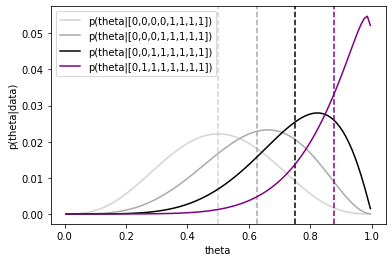

In [28]:
my_regularity_prior = calculate_prior(0.1, possible_pW1)
my_data1 = [0] * 4 + [1] * 4
my_data2 = [0] * 3 + [1] * 5
my_data3 = [0] * 2 + [1] * 6
my_data4 = [0] * 1 + [1] * 7
print('data1 = ',my_data1)
print('data2 = ',my_data2)
print('data3 = ',my_data3)
print('data4 = ',my_data4)

my_posterior1 = posterior(my_data1, my_regularity_prior, possible_pW1)
my_posterior2 = posterior(my_data2, my_regularity_prior, possible_pW1)
my_posterior3 = posterior(my_data3, my_regularity_prior, possible_pW1)
my_posterior4 = posterior(my_data4, my_regularity_prior, possible_pW1)

plt.plot(possible_pW1, my_posterior1,'lightgrey',label='p(theta|[0,0,0,0,1,1,1,1])')
plt.axvline(x=4/8,color='lightgrey',linestyle='--')
plt.plot(possible_pW1, my_posterior2,'darkgrey',label='p(theta|[0,0,0,1,1,1,1,1])')
plt.axvline(x=5/8,color='darkgrey',linestyle='--')
plt.plot(possible_pW1, my_posterior3,'black',label='p(theta|[0,0,1,1,1,1,1,1])')
plt.axvline(x=6/8,color='black',linestyle='--')
plt.plot(possible_pW1, my_posterior4,'purple',label='p(theta|[0,1,1,1,1,1,1,1])')
plt.axvline(x=7/8,color='purple',linestyle='--')
plt.xlabel("theta")
plt.ylabel("p(theta|data)")
plt.legend()

*And if I just add more data I can start to overcome the regularity prior - in the plot below I have just used the same ratios in the data, but 4 times as much of it, and the regularisation effect is very subtle. It'd be almost impossible to differentiate between this and probability matching in an experiment.*

data1 =  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
data2 =  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
data3 =  [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
data4 =  [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


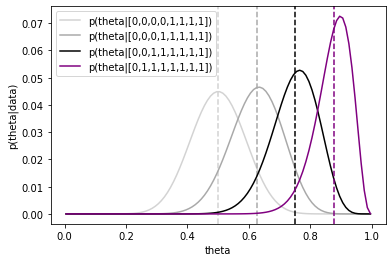

In [29]:
my_regularity_prior = calculate_prior(0.1, possible_pW1)
my_data1 = [0] * 16 + [1] * 16
my_data2 = [0] * 12 + [1] * 20
my_data3 = [0] * 8 + [1] * 24
my_data4 = [0] * 4 + [1] * 28
print('data1 = ',my_data1)
print('data2 = ',my_data2)
print('data3 = ',my_data3)
print('data4 = ',my_data4)

my_posterior1 = posterior(my_data1, my_regularity_prior, possible_pW1)
my_posterior2 = posterior(my_data2, my_regularity_prior, possible_pW1)
my_posterior3 = posterior(my_data3, my_regularity_prior, possible_pW1)
my_posterior4 = posterior(my_data4, my_regularity_prior, possible_pW1)

plt.plot(possible_pW1, my_posterior1,'lightgrey',label='p(theta|[0,0,0,0,1,1,1,1])')
plt.axvline(x=4/8,color='lightgrey',linestyle='--')
plt.plot(possible_pW1, my_posterior2,'darkgrey',label='p(theta|[0,0,0,1,1,1,1,1])')
plt.axvline(x=5/8,color='darkgrey',linestyle='--')
plt.plot(possible_pW1, my_posterior3,'black',label='p(theta|[0,0,1,1,1,1,1,1])')
plt.axvline(x=6/8,color='black',linestyle='--')
plt.plot(possible_pW1, my_posterior4,'purple',label='p(theta|[0,1,1,1,1,1,1,1])')
plt.axvline(x=7/8,color='purple',linestyle='--')
plt.xlabel("theta")
plt.ylabel("p(theta|data)")
plt.legend()

2. Can you produce a result like the Hudson Kam & Newport (2005) results *for children*, i.e. that children tend to regularise, sometimes producing only one variant even when their data contains variation? Again, what kinds of priors and what kinds of data does this work for?

*Actually this is really hard! If we give our model variable input (i.e. a mix of 1s and 0s in the data) it's going to do a decent job of estimating that, even if it has a strong regularity prior - see the previous answer. The only way you can get more regularisation-like behaviour is with very small samples of data and a strong regularity bias, or data that only contains one variant (i.e. is not variable). In the plot below I have small data and a very strong regularity prior and the model has a posterior which is skewed towards regularity. With really tiny amounts of data (4 items! shown in the red line) it wants to estimate that pW1 is very high, but even then it's got quite a lot of uncertainty and lower values of pW1 have quite high probability. Once we move to 8 data items (black line) the data starts overwhelming the prior - it's over-estimating the frequency of word 1, but it is not estimating that pW1 is 1 (the most extreme regularisation behaviour) because it's seen some occurences of word 0 in its data.*

*It's actually therefore a bit of a puzzle why children behave as they do in the Hudson Kam & Newport experiment - it certainly can't be easily accounted for with this kind of model, unless we assume e.g. that children can only remember a single variant (e.g. their data only contains word 1).*

data1 =  [0, 1, 1, 1]
data2 =  [0, 0, 1, 1, 1, 1, 1, 1]


Text(0, 0.5, 'p(theta|data)')

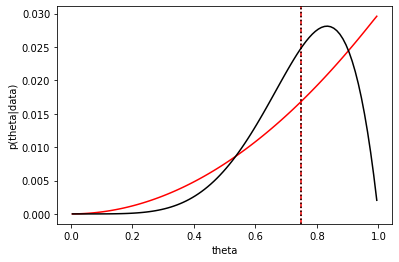

In [30]:
my_strong_regularity_prior = calculate_prior(0.001, possible_pW1)
my_data1 = [0] * 1 + [1] * 3
my_data2 = [0] * 2 + [1] * 6
print('data1 = ',my_data1)
print('data2 = ',my_data2)

my_posterior1 = posterior(my_data1, my_strong_regularity_prior, possible_pW1)
my_posterior2 = posterior(my_data2, my_strong_regularity_prior, possible_pW1)

plt.plot(possible_pW1, my_posterior1,'red')
plt.axvline(x=3/4,color='red',linestyle='--')
plt.plot(possible_pW1, my_posterior2,'black')
plt.axvline(x=3/4,color='black',linestyle=':')
plt.xlabel("theta")
plt.ylabel("p(theta|data)")

3. Do we have any kind of *innateness* in our model? Are there languages our model learner could never learn, no matter what kind of data we gave them? Are there languages they are predisposed to learn, or languages that they are predisposed to not learn?

*As with the lab 2 model, there are at least two kinds of innataness. First, languages that are not in our hypothesis space can never be learned – so if we don't include e.g. pW1=0.996321 in our hypothesis space, our learner can __never__ infer it. Then on top of that there's our prior – we can plug in different shapes of priors and create learners who are predisposed to regularity, or predisposed to variability. Again, I think one of the main advantages of these Bayesian models is being able to be really explicit about prior biases in this way.* 

4. [Optional, harder, mainly a coding problem] It turns out that one reason this type of model (known as the beta-binomial model) is so popular is that there is a handy shortcut for working out the posterior: if your prior is beta($\alpha, \alpha$) and you see $a$ occurences of word 0 and $b$ occurences of word 1 then your posterior distribution will also be a beta distribution, beta($\alpha + b$, $\alpha + a$). We won't be using this shortcut because we'll be moving on from beta-binomial models shortly and our grid technique works for all the examples we are going to be dealing with, but for fun: can you use the `beta.pdf()` function to write a new version of the `posterior()` function? And can you use the function `beta.rvs(x,y)` (which samples a random number from a beta distribution with parameters `x` and `y`) to replace our `learn()` function above? *Tip: so far we have been using beta distributions which have the same value for both `x` and `y`. This makes the beta distribution symmetrical, which makes sense because we're assuming the prior does not prefer word over word two or vice versa. However, when it come to the posterior, we obviously are expecting learners to end up preferring one or other of the words. This is where the asymmetrical beta distribution comes in, which lets you specify whether the distribution will be skewed towards word one or word two by making `x` and `y` be different numbers. Have a play with this if you want, but really this question is only for folks who want to dig further into the mathematics behind all this, and if that's not for you then feel free to skip!*

*This one is really only for people who can already code and are possibly already annoyed that we aren't using this shortcut! For everyone else, it's not important to look at this question.*

*My `shortcut_posterior()` function takes data and the alpha value, counts the number of occurences of word 0 and word 1, then uses `beta.pdf()` and `normalize_probs()` to calculate the posterior directly. I then plot posteriors obtained from the two techniques so we can verify they are the same – the two lines appear on top of each other, so we are good.*

In [31]:
def shortcut_posterior(data, prioralpha, possible_pW1):
    nW1 = sum(data) #cheeky trick to count the number of occurences of word 1 in data
    nW0 = len(data)-nW1 #then this is the number of word 0s
    posterior_probs = [] #this list will hold the posterior for each possible value of pW1
    for i in range(len(possible_pW1)): #work through the list of pW1 values, by index
        pW1 = possible_pW1[i] #look up that value of pW1
        posterior_probs.append(beta.pdf(pW1, prioralpha+nW1, prioralpha+nW0))
    return normalize_probs(posterior_probs) #normalise

data =  [0, 0, 1, 1, 1, 1, 1, 1]


Text(0, 0.5, 'p(theta|data)')

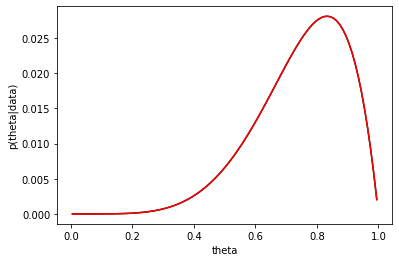

In [32]:
my_strong_regularity_prior = calculate_prior(0.001, possible_pW1)
my_data = [0] * 2 + [1] * 6
print('data = ',my_data)

my_posterior1 = posterior(my_data,my_strong_regularity_prior, possible_pW1) #old technique
my_posterior2 = shortcut_posterior(my_data,0.001, possible_pW1) #shortcut

plt.plot(possible_pW1, my_posterior1,'black')
plt.plot(possible_pW1, my_posterior2,'red')
plt.xlabel("theta")
plt.ylabel("p(theta|data)")

*The shortcut version of `learn()` works in the same way but is even faster – we don't even have to lay out the grid and calculate the posterior, `beta.rvs()` will sample direct from the posterior for us. Below I specify my function then run it a bunch of times to verify that it is sampling the expected sort of values (in this case, for the same data as we used to test out the `learn()` function, so it should be sampling values of pW1 around 0.75.*

In [33]:
def shortcut_learn(data,prioralpha):
    nW1 = sum(data) 
    nW0 = len(data)-nW1 
    sampled_pW1 = beta.rvs(prioralpha+nW1,prioralpha+nW0)
    return sampled_pW1

In [34]:
my_data = [0] * 2 + [1] * 6
print(shortcut_learn(my_data,1))
print(shortcut_learn(my_data,1))
print(shortcut_learn(my_data,1))
print(shortcut_learn(my_data,1))
print(shortcut_learn(my_data,1))
print(shortcut_learn(my_data,1))
print(shortcut_learn(my_data,1))
print(shortcut_learn(my_data,1))
print(shortcut_learn(my_data,1))
print(shortcut_learn(my_data,1))

0.920416993524352
0.38330524089504775
0.47669525534172213
0.8185835984640274
0.4186101888201278
0.5385531791633582
0.7402711981986535
0.6096679877504196
0.6773680877056947
0.6674448395778763
